In [1]:
%matplotlib inline
from netCDF4 import Dataset as ncread
import netCDF4 as nc
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
import pandas as pd
from datetime import datetime
from itertools import product
from cftime import DatetimeNoLeap
import xarray as xr

/home/aspring/.local/lib/python3.8/site-packages/pandas/compat/_optional.py:161: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
from preprocess import get_principle_components_and_EOFs
import os

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
import matplotlib.path as mpath

In [4]:
from datetime import datetime 
from datetime import timedelta
from datetime import date
import time

In [5]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.utils import shuffle

In [7]:
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

2022-09-07 08:11:23.751322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 08:11:23.751357: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data set

Frozen({'latitude': 28, 'longitude': 31})

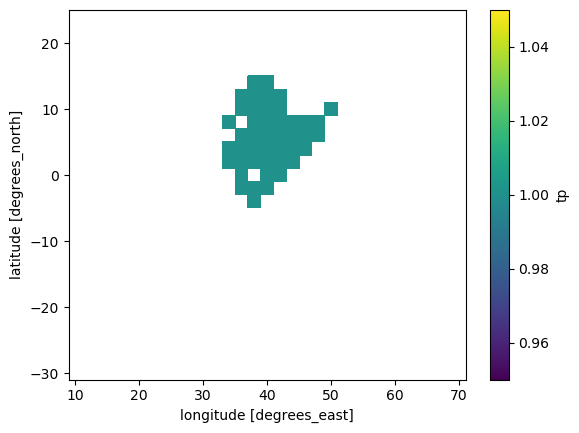

In [8]:
# Import regional mask
root_data = '/data/volume_2/observational/raw/'

import pathlib
root_results = str(pathlib.Path.home() / 'Results')

file = '/data/volume_2/observational/era5_hoa_dry_mask_2deg.nc' #0.25

mask=xr.open_mfdataset(file,combine='by_coords',parallel=True)
mask_nan=mask.where(mask==1) #keep the values==1 and mask the rest
mask_nan.tp.plot()
mask_nan.sizes

#### Prepare target 
#### define drought events when 31-day running mean rainfall in OND from 1980-2021 is below the 33rd percentile, the tercile is calculated based on the 2000-2020 period

In [9]:
# Calculate the spatial mean of the tp file after applying the spatial mask

file=xr.open_mfdataset(root_data+f'/era5_tp_1959-2021_1_12_daily_2.0deg.nc',
                          combine='by_coords',parallel=True)
tp_dim=file.sel(longitude=slice(10,70),latitude=slice(24,-30))
tp_series=np.multiply(mask_nan,tp_dim).mean(dim='latitude',skipna=True).mean(dim='longitude',skipna=True)

# Calculate 33 percentile
# Create daily values equal to a 31 day rolling. Select OND 2000-2020 data to decide the quantile threshold
tp_rol=tp_series.rolling(time=31, center=True).mean().sel(time=tp_series.time.dt.year.isin([np.arange(2000,2021)]))
tp_quantile=tp_rol.sel(time=tp_rol.time.dt.month.isin([10,11,12])).quantile(0.33)
print('value of the 33 percentile',tp_quantile.tp.values)

# Create index time series
# Replace the values bellow the 33 percentile with 1 and the rest with zeros
SYY = 1980   # start year, could be changed
EYY = 2021   # end year, could be changed
tp_rol = tp_series.rolling(time=31, center=True).mean().sel(time=tp_series.time.dt.month.isin([10,11,12]))
tp_rol_sel = tp_rol.sel(time = slice(str(SYY),str(EYY)))
tp_index = tp_rol_sel < tp_quantile
tp_index = tp_index.astype(int)
print('tp index',tp_index)

value of the 33 percentile 0.00027705061818355853
tp index <xarray.Dataset>
Dimensions:   (time: 3864)
Coordinates:
  * time      (time) datetime64[ns] 1980-10-01 1980-10-02 ... 2021-12-31
    quantile  float64 0.33
Data variables:
    tp        (time) int64 dask.array<chunksize=(3863,), meta=np.ndarray>


number of 0 and 1:  (array([0, 1]), array([1939,  665]))
<xarray.Dataset>
Dimensions:   (time: 2604)
Coordinates:
  * time      (time) datetime64[ns] 1980-10-16 1980-10-17 ... 2021-12-16
    quantile  float64 0.33
Data variables:
    tp        (time) int64 dask.array<chunksize=(62,), meta=np.ndarray>
(2604,)


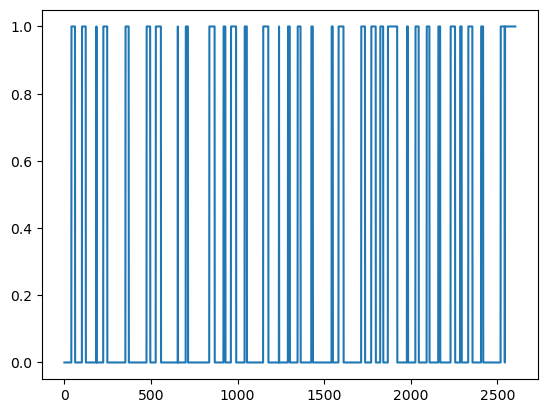

In [10]:
# Select from the index time series the period for the target values (predictant) 
# Oct 16 to Dec 16 for the period 1980-2020 (each day corresponds to a 31-day rolling mean)
# The chosen time period could be changed to any time period you want
for iyr in range(SYY,EYY+1):
    if iyr == SYY:
        tp_target = tp_index.sel(time = slice(str(iyr)+'-10-16',str(iyr)+'-12-16'))
    else:
        tp_target = xr.concat([tp_target,tp_index.sel(time = slice(str(iyr)+'-10-16',str(iyr)+'-12-16'))], dim='time')
print('number of 0 and 1: ',np.unique(tp_target['tp'],return_counts=True))
print(tp_target)
plt.plot(tp_target.tp)

# Make it into a numpy array
target = tp_target['tp'].values
print(target.shape)

#### Prepare predictors: 30 days time series with the last day two weeks before the target day

In [11]:
# Predictor data preprocessing
# can select the values and region you want by changing the parameters

file_vars = ['ERA5_t2m', 'era5_t_850hpa', 'era5_z_200hpa', 'era5_z_500hpa', 'sst', 'era5_olr']
#file_vars = ['sst']
header_vars = ['t2m', 't', 'z', 'z', 'sst', 'olr-mean']
#header_vars = ['sst']

# select regions for the individual predictor
lon_slices = [[-16,54],[-30,90],[-30,90],[-30,90],[-180,180],[40,180]]
lat_slices = [[16,0],[30,-20],[-20,30],[-20,30],[40,-20],[-20,20]]

nmode = 5 # for eofs

for file_var, header_var, lon_slice, lat_slice in zip (file_vars, header_vars, lon_slices, lat_slices):
    # use existing
    path = root_results+'PC_series_n_'+str(nmode)+'_var_'+file_var+'_.nc'
    if os.path.exists(path):
        continue
    if file_var == 'era5_olr':
        file = xr.open_dataset(root_data+file_var+'_1950_2021_daily_1deg_tropics.nc')
        print('olr')
    else:
        file = xr.open_dataset(root_data+file_var+'_1959-2021_1_12_daily_2.0deg.nc')
        print(header_var)

    if "longitude" in file.coords:
        file = file.rename({"longitude": "lon","latitude": "lat"})

    assert "lat" in file.coords
    assert "lon" in file.coords
    
    # select region
    var_dim = file.sel(lon=slice(lon_slice[0],lon_slice[1]),lat=slice(lat_slice[0],lat_slice[1]))
    
    # take years 1980 - 2021 daily and only and 7 day rolling mean
    var_series = var_dim.sel(time=var_dim.time.dt.year.isin([np.arange(SYY,EYY+1)])).rolling(time=7, center=False).mean(skipna=True)
    
    # remove climatology
    var_anom_series = var_series.groupby("time.dayofyear") - var_series.groupby("time.dayofyear").mean("time",skipna=True)
    
    # use the months you want (base on how long the time series used as predictors)
    var_anom_sel = var_anom_series.sel(time=var_anom_series.time.dt.month.isin([7,8,9,10,11]))[header_var]
    
    # Apply EOF
    pc_xr, EOF = get_principle_components_and_EOFs(var_anom_sel, nmode=nmode)
    # save to disk
    pc_xr.to_netcdf(path)

sst
the first 5 modes explain 47.0% of the total variance of sst


In [12]:
# quick viz
# pc_xr.plot(hue="mode", figsize=(20,3))
# var_anom_series[header_var].isel(time=122).plot(size=5, aspect=4)

In [18]:
start = time.time()
SMM = 10
SDD = 16
EMM = 12
EDD = 16
ntimestep = 60
rw = 31 # running mean window
half_rw = int(rw/2)
lead_time = 14
rw_1 = 7 # running mean window for predictor
# 31-day running mean so 15 days before the central day + 2 weeks in advance + 7-day running mean + 30-day time steps

# Import predictors if the predictors have been saved before
nmode=5
var_num=6
pc_xr = xr.open_mfdataset(root_results+'PC_serie*.nc',concat_dim="mode",combine="nested")# Frozen({'time': 6273, 'mode': 30})

date_target = datetime.strftime(datetime(year=SYY,month=SMM,day=SDD), "%Y.%m.%d")
pc_predictor = np.ndarray((len(tp_target['tp']),ntimestep,nmode*var_num))
it = 0
ii = 0
YYY = SYY
while YYY < EYY+1:
    date_start = datetime.strftime(datetime.strptime(date_target, "%Y.%m.%d")-timedelta(days=half_rw+lead_time+rw_1+ntimestep-1),"%Y.%m.%d")
    date_end = datetime.strftime(datetime.strptime(date_target, "%Y.%m.%d")-timedelta(days=half_rw+lead_time+rw_1),"%Y.%m.%d")
    #print(date_target,date_start,date_end,it)
    #pc_predictor[ii,:,:] = pc_xr.sel(time = slice(date_start,date_end)).values
    pc_predictor[ii,:,:] = pc_xr.sel(time = slice(date_start,date_end))['pcs'].values
    if date_target == datetime.strftime(datetime(year=YYY,month=EMM,day=EDD),"%Y.%m.%d"):
        YYY = YYY+1
        date_target = datetime.strftime(datetime(year=YYY,month=SMM,day=SDD), "%Y.%m.%d")
        it = 0
        print(YYY)
    else:
        it = 1
    ii = ii+1
    date_target = datetime.strftime(datetime.strptime(date_target, "%Y.%m.%d")+timedelta(days=it),"%Y.%m.%d") 
end = time.time()
duration = end-start
print("Time took {:3.1f} min".format(duration/60))

1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
Time took 0.4 min


In [ ]:
# plot EOF modes
import visualization
visualization.plot_oef_mode(EOF, PC, lon, lat)

## Splitting the data

In [ ]:
def get_train_test_val(data_predictor, data_target, test_frac, val_frac):
    """Splits data across periods into train, test, and validation"""
    # assign the last int(-test_frac*len(tp_predictor)) rows to test data
    test_predictor = data_predictor[int(-test_frac*len(data_target)):]
    test_target = data_target[int(-test_frac*len(data_target)):]
    
    # assign the last int(-test_frac*len(tp_predictor)) from the remaining rows to validation data
    remain_predictor = data_predictor[0:int(-test_frac*len(data_target))]
    remain_target = data_target[0:int(-test_frac*len(data_target))]
    val_predictor = remain_predictor[int(-val_frac*len(remain_predictor)):]
    val_target = remain_target[int(-val_frac*len(remain_predictor)):]
    
    # the remaining rows are assigned to train data
    train_predictor = remain_predictor[:int(-val_frac*len(remain_predictor))]
    train_target = remain_target[:int(-val_frac*len(remain_predictor))]
    return train_predictor, train_target, test_predictor, test_target, val_predictor, val_target

In [ ]:
# define input and output data for LSTM
y_all = keras.utils.to_categorical(target)
X_all = pc_predictor
print(X_all.shape,y_all.shape)

In [ ]:
train_X, train_y, test_X, test_y, val_X, val_y = get_train_test_val(X_all, y_all, test_frac=0.2, val_frac=0.2)

In [ ]:
visualization.plot_split_counts(train_y, val_y, test_y)

## LSTM with attention layer

In [ ]:
# https://github.com/gentaiscool/lstm-attention/blob/58adc7e345b5b3a79638483049704802a66aa1f4/layers.py#L50
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    follows these equations:
    
    (1) u_t = tanh(W h_t + b)
    (2) \alpha_t = \frac{exp(u^T u)}{\sum_t(exp(u_t^T u))}, this is the attention weight
    (3) v_t = \alpha_t * h_t, v in time t
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        3D tensor with shape: `(samples, steps, features)`.
    """

    def __init__(self,
                W_regularizer=None, u_regularizer=None, b_regularizer=None,
                W_constraint=None, u_constraint=None, b_constraint=None,
                bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                initializer=self.init,
                                name='{}_W'.format(self.name),
                                regularizer=self.W_regularizer,
                                constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                    initializer='zero',
                                    name='{}_b'.format(self.name),
                                    regularizer=self.b_regularizer,
                                    constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                initializer=self.init,
                                name='{}_u'.format(self.name),
                                regularizer=self.u_regularizer,
                                constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero and this results in NaN's. 
        # Should add a small epsilon as the workaround
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        
        return weighted_input, a

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[1], input_shape[2]
    
class Addition(Layer):
    """
    This layer is supposed to add of all activation weight.
    We split this from AttentionWithContext to help us getting the activation weights
    follows this equation:
    (1) v = \sum_t(\alpha_t * h_t)
    
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    """

    def __init__(self, **kwargs):
        super(Addition, self).__init__(**kwargs)

    def build(self, input_shape):
        self.output_dim = input_shape[-1]
        super(Addition, self).build(input_shape)

    def call(self, x):
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [ ]:
#Create a class weight dictionary to help if the classes are unbalanced
def class_weight_creator(Y):
    class_dict = {}
    weights = np.max(np.sum(Y, axis=0)) / np.sum(Y, axis=0)
    for i in range( Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [ ]:
class_weight = class_weight_creator(train_y)

In [ ]:
batch_size = 32
epochs = 30
shuffle = True 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [ ]:
callbacks_path = '/home/zwu/Lorentz_workshop/test/checkpoint_test'
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=callbacks_path,
        monitor='val_acc',   # tf.keras.metrics.AUC(from_logits=True)
        save_best_only=True,
    )
]

In [ ]:
# LSTM with attention layer
ntimestep = 60    # number of time step used in the predictors
nfeature = 30   # number of features
input_tensor = Input(shape=(ntimestep,nfeature))
layer1 = layers.LSTM(100, return_sequences=True, kernel_regularizer=regularizers.l2(1))(input_tensor)
layer1 = layers.LSTM(20, return_sequences=True, kernel_regularizer=regularizers.l2(0.01))(layer1)
layer1, alfa = AttentionWithContext()(layer1)
layer1 = Addition()(layer1)
layer1 = layers.Dense(5, activation="relu")(layer1)
output_tensor = layers.Dense(2,activation='softmax')(layer1)

model = Model(input_tensor, output_tensor)
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['acc'])

model.summary()

In [ ]:
# train the model
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_X, val_y), shuffle = shuffle, verbose=verbose, class_weight=class_weight)

In [ ]:
# plot learning curve
visualization.plot_learning_curve(history)

In [ ]:
# evaluation
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
test_predict = model.predict(test_X)
y_pred = np.argmax(model.predict(test_X),axis=1)
print('Recall: '+str(round(recall_score(test_y[:,1],y_pred),2)))
print('Precision: '+str(round(precision_score(test_y[:,1],y_pred),2)))
print('F1-score: '+str(round(f1_score(test_y[:,1],y_pred),2)))
print('Accuracy: '+str(round(accuracy_score(test_y[:,1],y_pred),2)))
print('Brier score:' +str(brier_score_loss(test_y[0:-20,1], test_predict[0:-20,1])))

calib_y, calib_x = calibration_curve(test_y[:,1],test_predict[:,1],n_bins=10)
visualization.plot_calibration_curve(calib_x, calib_y)

In [ ]:
visualization.plot_roc_auc(model, test_X, test_y)


In [ ]:
# get weightings of each time step and each sample
intermediate_layer_model2 = Model(inputs=model.input,
                                 outputs=model.layers[3].output)

intermediate_layer_model1 = Model(inputs=model.input,
                                 outputs=model.layers[2].output)

intermediate_layer_model3 = Model(inputs=model.input,
                                 outputs=model.layers[4].output)

intermediate_output2, alfa_output = intermediate_layer_model2.predict(test_X, verbose=0)
intermediate_output1 = intermediate_layer_model1.predict(test_X, verbose=0)
intermediate_output3 = intermediate_layer_model3.predict(test_X, verbose=0)

weights = intermediate_output2 / intermediate_output1
print(np.shape(weights))

In [ ]:
# plot the weights
val_weights = np.ndarray((len(test_X),ntimestep))+np.nan
for ii in range(len(test_X)):
    for j in range(ntimestep):
        val_weights[ii,j] = weights[ii][j][0]
print(np.shape(val_weights))

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
for ii in range(len(test_X)):
    plt.plot(val_weights[ii,:])

fig, axs = plt.subplots(1, figsize=plt.figaspect(0.15))
plt.plot(np.nanmean(val_weights,axis=0),'k')

In [ ]:
# SST predictor
root_data = '/s2s_nobackup/zhengwu/workshop/'
file = xr.open_mfdataset(root_data+f'/era5_sst_1959-2021_1_12_daily_2.0deg.nc',
                          combine='by_coords',parallel=True)
#sst_dim = file.sel(longitude=slice(50,180),latitude=slice(40,-20))
sst_dim = file.sel(latitude=slice(40,-20))
lon = sst_dim.coords['longitude'].values
lat = sst_dim.coords['latitude'].values
nlon = len(lon)
nlat = len(lat)

sst_series = sst_dim.sel(time=sst_dim.time.dt.year.isin([np.arange(SYY,EYY+1)])).rolling(time=7, center=False).mean(skipna=True)
print(sst_series)

sst_anom_series = sst_series.groupby("time.dayofyear") - sst_series.groupby("time.dayofyear").mean("time",skipna=True)

# EOF focus on July to Sep
sst_anom_sel = sst_anom_series.sel(time=sst_anom_series.time.dt.month.isin([7,8,9,10,11]))['sst'].values
# first, make a grid out of the longitude and latitude vectors so they have the same dimensions 
lon2d,lat2d = np.meshgrid(lon,lat)
wgts = np.cos(lat2d/180*np.pi)**0.5
print(wgts.shape)
solver = Eof(sst_anom_sel,weights=wgts)

# EOFs are multiplied by the square-root of their eigenvalues (then the EOF patterns will carry the units)
nmode = 4
EOF = solver.eofs(neofs=nmode,eofscaling=2) # get the first four eofs
print(np.shape(EOF))
eigenv = solver.eigenvalues(neigs=nmode)
print(eigenv)
VarEx = solver.varianceFraction(neigs=nmode)*100
print(sum(VarEx))
PC = solver.pcs(npcs=nmode,pcscaling=1)
print(np.shape(PC))

mode = np.arange(nmode)
sst_anom_dim = sst_anom_series.sel(time=sst_anom_series.time.dt.month.isin([7,8,9,10,11]))
time_dim = sst_anom_dim.coords['time']
print(sst_anom_dim.coords['time'])
pc_xr = xr.DataArray(PC, coords={'time': time_dim, 'mode': mode}, dims=["time","mode"])
